In [67]:
## jupyter notebook に最初に記述tenplate

"""
2021.09.27 今回参考にしたものについて
https://qiita.com/ku_a_i/items/0ea4b93d767ce7c83145
"""
https://qiita.com/ku_a_i/items/0ea4b93d767ce7c83145
### ------------------------------------------------
# basic-module
import matplotlib.pyplot as plt
import sys,os,re,glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import seaborn as sns
# sori -module
# sys.path.append('/home/ysorimachi/tool')
# from getErrorValues import me,rmse,mae,r2 #(x,y)
# from convSokuhouData import conv_sfc #(df, ave=minutes,hour)

# #---------------------------------------------------
# import subprocess
# import requests
# #--------------------------
# import pickle
# import gzip
# from pathlib import Path

# deep learning modules 
# imports

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary #torchinfoはニューラルネットの中身を見れるのでおすすめ

In [45]:
#参考の資料について
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

def load_df(path, isDAY=True):
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["time"])
    df["dd"] = df["time"].apply(lambda x: x.strftime("%Y%m%d"))
    df["hh"] = df["time"].apply(lambda x: x.strftime("%H"))
    
    if isDAY:
        df = df.groupby("dd").agg({"DEMAND(10^4kW)" : "mean"})
    return df

def plot_df(df,_col):
    f,ax = plt.subplots(figsize=(18,8))
    for c in _col:
        ax.plot(df[c],label=c)
    
    ax.legend(loc="upper right")
    plt.show()
    return

def cut_time(df,st,ed=None):
    if ed:
        return df[(df["time"]>=st)&(df["time"]<=ed)]
    else:
        return df[df["time"]>=st]

def move_ave(df,col,lag=7):
    new_col  = f"MA{lag}_{col}"
    df[new_col]= df[col].rolling(lag).mean()
    return df

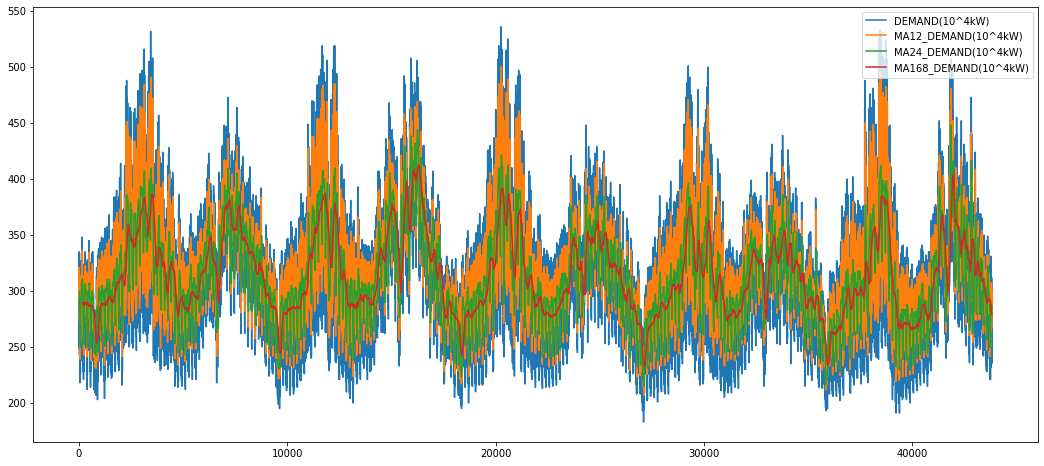

In [46]:
path="/home/ysorimachi/work/sori_py2/deepl/dat/data/power/all_demand2.csv"

df = load_df(path,isDAY=False)
df = cut_time(df,st=datetime(2016,4,1,0,0),ed=datetime(2021,4,1,0,0))
df = move_ave(df,"DEMAND(10^4kW)",lag=12)
df = move_ave(df,"DEMAND(10^4kW)",lag=24)
df = move_ave(df,"DEMAND(10^4kW)",lag=24*7)

_col = [ c for c in df.columns if "DEMAND" in c]
# _col = ["DEMAND(10^4kW)","ESTIMATE(10^4kW)"]
plot_df(df,_col =_col)


In [104]:
def get_data(c="MA24_DEMAND(10^4kW)",len_time=10,st=datetime(2016,4,1,0,0),ed=datetime(2019,3,31,0,0)):
    df= load_df(path,isDAY=False)
    df = move_ave(df,"DEMAND(10^4kW)",lag=24)
    df = move_ave(df,"DEMAND(10^4kW)",lag=24*7)
    df = df[df["hh"]=="12"]
    
    df = cut_time(df,st=st,ed=ed)
    df = df.dropna(subset=["MA24_DEMAND(10^4kW)"])
    df = df[c].values
    
    mms = MinMaxScaler()
    df = mms.fit_transform(df.reshape(-1,1)) #正規化する
    #-----------------------------------------------
    _x0,_t0 = [],[]
    n_data = df.shape[0]-1-len_time
#     print(n_train)
    for i in range(n_data+1):
        _x0.append(df[i:i+len_time])
        _t0.append(df[i+len_time])
    _x0 = np.array(_x0)
    _t0 = np.array(_t0).reshape(-1,1)
    return _x0,_t0


from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

def mk_dataloader(c="MA24_DEMAND(10^4kW)",len_time=10,isTrain=True):
    if isTrain:
        _x,_t= get_data(c=c,len_time=len_time,st=datetime(2016,4,1,0,0),ed=datetime(2019,3,31,0,0))
        shuffle=True
        batch_size=16
    else:
        _x,_t= get_data(c=c,len_time=len_time,st=datetime(2019,4,1,0,0),ed=datetime(2020,3,31,0,0))
        shuffle=False
        batch_size=32
        
    tensor_x = torch.tensor(_x,dtype=torch.float32)
    tensor_t = torch.tensor(_t,dtype=torch.float32)
    
    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_t)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

# 
# df =  load_df(path,isDAY=True)
# df = df.reset_index()
# plot_df(df,_col =["DEMAND(10^4kW)"])
# _x,_t = get_data(len_time=10)
# print(_x.shape,_t.shape)

In [105]:
class PowerRNN(nn.Module):
    def __init__(self,input_size, output_size,hidden_dim, n_layer):
        super(PowerRNN,self).__init__()
        
        self.input_size = input_size
#         self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layer = n_layer
        
        self.rnn = nn.RNN(input_size,hidden_dim,n_layer, batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_size)#全結合層で、最終的な予測値を1つに絞って出力を行うようにする
        
    def forward(self,x):
        y_rnn,h = self.rnn(x,None)
        y = self.fc(y_rnn[:,-1,:])
        return y
        

In [106]:
input_size = 1
output_size =1
n_hidden = 64
n_layer = 1
len_time = 10

def setting():
    seed = 724
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
# batch_size = 4
# summary(net,(batch_size,len_time,1))


In [164]:
# fitting 

class Trainer():
    def __init__(self, model,optimizer,n_epoch=200):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = nn.MSELoss()
#         self.data_laoder = data_loader
        self.n_epoch = n_epoch
        
        self.device =torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  #デバイス(GPU or CPU)設定
        self.model.to(self.device)
        #record
        self._loss =[]
        self._pred = []
        
    def fit(self, data_loader):
        run_loss=0
        # Epoch (train) -------------------------------->
        for i in range(self.n_epoch):
            # train ----mode-------------
            self.model.train() #学習モード
            for j,(x,t) in enumerate(data_loader):
                x = x.to(self.device)
                self.optimizer.zero_grad() #勾配の初期化
                y= self.model(x)
                y = y.to('cpu')
                loss = self.loss_func(y,t)
                loss.backward()
                optimizer.step()
                
                run_loss += loss.item()
            
            run_loss /= j+1 #平均誤差
            self._loss.append(run_loss)
            
            # valid ----mode-------------
            if i%10 == 0: #20 epoch毎に予測の様子を表示してみる
                print(f"Epoch {i} | run_loss = {run_loss}")
#                 self.model.eval() #検証モード
#                 _predict = []
                      
        # Epoch (train) -------------------------------->
    
    def predict(self,data_loader):
        self.model.eval() # 検証モード
        for j,(x,t) in enumerate(data_loader):
            
            x = x.to(self.device)
            y = self.model(x)
            y = y.to('cpu')
            y = y.detach().numpy().reshape(-1,).tolist()
#             self._pred.append(y)
            self._pred += y
    
    def plot_loss(self):
        f,ax = plt.subplots(figsize=(18,8))
        ax.plot(np.arange(len(self._loss)),self._loss, label="loss")
        plt.show()
        return

In [165]:
net = PowerRNN(input_size,output_size,n_hidden, n_layer)
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_loader = mk_dataloader(c="MA24_DEMAND(10^4kW)",len_time=10,isTrain=True)
test_loader = mk_dataloader(c="MA24_DEMAND(10^4kW)",len_time=10,isTrain=False)

trainer = Trainer(net,optimizer,n_epoch=20)
trainer.fit(train_loader)
# trainer.plot_loss()

Epoch 0 | run_loss = 0.05048530737814658
Epoch 10 | run_loss = 0.004834465890423283


In [166]:
trainer.predict(test_loader)

In [168]:
trainer._pred

[0.44279512763023376,
 0.5069071054458618,
 0.38496410846710205,
 0.2536589503288269,
 0.25176066160202026,
 0.45974618196487427,
 0.473029226064682,
 0.4047577381134033,
 0.378486305475235,
 0.3007217347621918,
 0.22730226814746857,
 0.2005826085805893,
 0.3134555220603943,
 0.38499975204467773,
 0.3774590492248535,
 0.4013490378856659,
 0.2994444966316223,
 0.17468632757663727,
 0.1951429545879364,
 0.2738340497016907,
 0.29867464303970337,
 0.2087177336215973,
 0.15287168323993683,
 0.07178176939487457,
 0.005623951554298401,
 0.06973116844892502,
 0.1646651029586792,
 0.23923403024673462,
 0.26905226707458496,
 0.2763103246688843,
 0.287028968334198,
 0.23227988183498383,
 0.1442098468542099,
 0.28995418548583984,
 0.43909233808517456,
 0.3223991096019745,
 0.3748033940792084,
 0.32306474447250366,
 0.20247980952262878,
 0.19089502096176147,
 0.3462725877761841,
 0.3836265206336975,
 0.33934634923934937,
 0.40095773339271545,
 0.33987072110176086,
 0.23596413433551788,
 0.253216028